# Generating true time series data

An essential part of estimating detection power is creating a "True receptor concentration time series", that is a time series of the concentration without any of the noise.

Before we get too far, lets set up the notebook and import the required packages.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gw_detect_power import DetectionPowerSlope
from scipy.interpolate import interp1d

## Bespoke time series data

Bespoke time series data needs to be re-sampled to the sampling frequency that you want to use for the detection power analysis.  The pandas library has a number of functions that can be used to do this. Just recall that the detection power analysis assumes a regular sampling frequency.

For instance, below we create a weekly time series for 10 years with a linear decreasing trend. We then resample this to a monthly frequency.

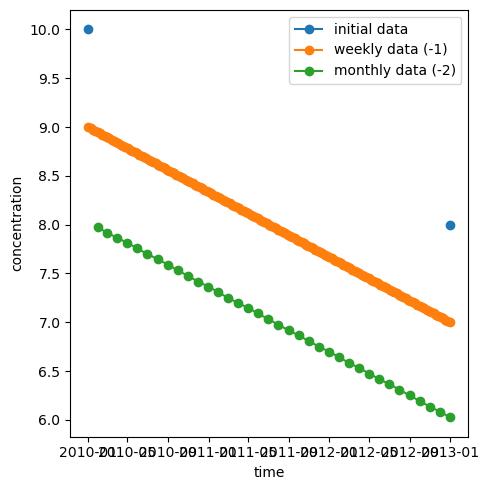

In [6]:
initial_data = pd.Series(index=pd.date_range(start='2010-01-03', end='2012-12-31', freq='W'))
initial_data.loc['2010-01-03'] = 10
initial_data.loc['2012-12-30'] = 8
interpolated_data = initial_data.interpolate(method='linear')
monthly_data = interpolated_data.resample('M').mean()
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(initial_data.index, initial_data, label='initial data', marker='o')
ax.plot(interpolated_data.index, interpolated_data-1, label='weekly data (-1)', marker='o')
ax.plot(monthly_data.index, monthly_data-2, label='monthly data (-2)', marker='o')
ax.set_xlabel('time')
ax.set_ylabel('concentration')
ax.legend()
fig.tight_layout()
plt.show()

### Transition date to years since sampling began
The detection power calculator operates in a float years format.  So time series data needs to be transitioned to this format.  Options include resampling as a timeseries then converting:

In [7]:
monthly_data = interpolated_data.resample('M').mean()
x = (monthly_data.index - monthly_data.index.min()).days / 365.25

Alternatively, you can transition to years from the start of the time series early and use scipy.interpolate.interp1d to interpolate the data to the required sampling frequency.

In [8]:
x = (interpolated_data.index - interpolated_data.index.min()).days / 365.25
sampler = interp1d(x, interpolated_data.values)
x_new = np.arange(0, 3, 1 / 12) # monthly sampling for 3 years

## Piston flow model

the "truets_from_piston_flow" function allows the user to generate time series data from the piston flow model.

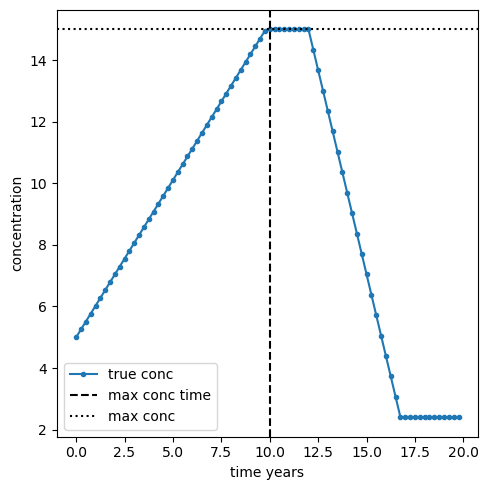

In [9]:
dpc = DetectionPowerSlope()
output = dpc.truets_from_piston_flow(mrt=12, initial_conc=5, target_conc=2.4,
                            prev_slope=1, max_conc=15, samp_per_year=4, samp_years=20,
                                implementation_time=5)
true_conc_ts=output[0]
max_conc = output[1]
max_conc_time=output[2]
frac_p2=output[3] # dummy value as this is a piston flow model
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(np.arange(len(true_conc_ts))/4, true_conc_ts, label='true conc', marker='.')
ax.axvline(max_conc_time, color='k', linestyle='--', label='max conc time')
ax.axhline(max_conc, color='k', linestyle=':', label='max conc')
ax.set_xlabel('time years')
ax.set_ylabel('concentration')
ax.legend()
fig.tight_layout()
plt.show()

# Binary piston flow model

Similarly, the binary piston flow model can be used to generate time series data.


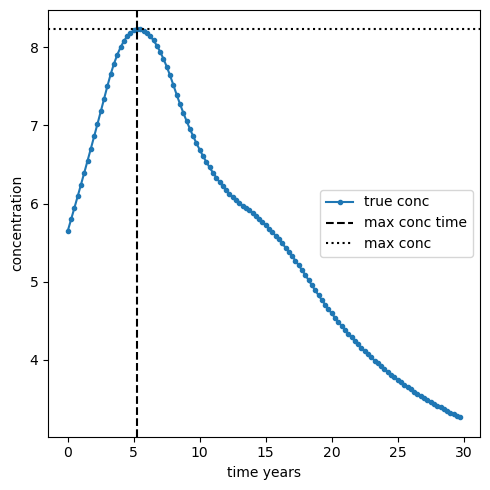

In [10]:
dpc = DetectionPowerSlope()
output = dpc.truets_from_binary_exp_piston_flow(mrt=15,
                                                mrt_p1=10,
                                                frac_p1=0.7,
                                                f_p1=0.7, f_p2=0.5,
                                                initial_conc=5.6, target_conc=2.4,
                                                prev_slope=0.5,
                                                max_conc=20,
                                                min_conc=1,
                                                samp_per_year=4, samp_years=30,
                                                implementation_time=5, past_source_data=None,
                                                return_extras=False, low_mem=False,
                                                precision=2)

true_conc_ts = output[0]
max_conc = output[1]
max_conc_time = output[2]
frac_p2 = output[3]
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(len(true_conc_ts)) / 4, true_conc_ts, label='true conc', marker='.')
ax.axvline(max_conc_time, color='k', linestyle='--', label='max conc time')
ax.axhline(max_conc, color='k', linestyle=':', label='max conc')
ax.set_xlabel('time years')
ax.set_ylabel('concentration')
ax.legend()
fig.tight_layout()
plt.show()
plt.close(fig)

## Auto mode generation

The Auto classes (AutoDetectionPowerSlope & AutoDetectionPowerCounterFactual) facilitate the generation of time series as part
of the detection power analysis call.  The user specifies:

* an initial concentration
* a target concentration
* implementation time 
* sampling frequency
* sampling duration
* the slope of the previous data
* the maximum concentration limit
* the minimum concentration limit
* the model to use for the mean residence time (piston flow or binary exponential piston flow)
* the mean residence time and other parameters for the age model

The auto function then generates a source time series, propagates it onto the receptor (via the age model) and resamples it to the expected frequency.